# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Prepration

In [30]:
train_df = pd.read_csv('train_data.csv')[['New_Sentence', 'Type']]
test_df = pd.read_csv('test_data.csv')

<AxesSubplot: >

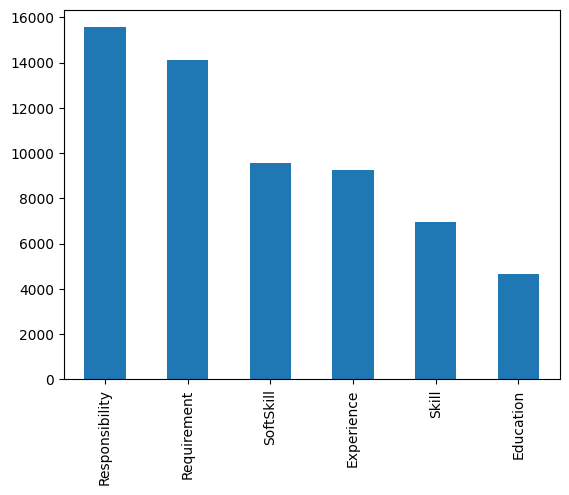

In [31]:
train_df.Type.value_counts().plot(kind='bar')

## Data Preprocessing

## Remove invalid(Na) sentences

In [32]:
train_df.isna().sum()

New_Sentence    1113
Type               0
dtype: int64

In [33]:
train_df = train_df.dropna()

## Data split

In [34]:
## Source - Sklearn documents (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
raw_train_x,raw_dev_x,train_y,dev_y = train_test_split( train_df.New_Sentence, train_df.Type, test_size=0.2,stratify=train_df.Type, random_state=2)

## Data Processing

### Data Cleaning

In [8]:
def preprocess(train_x):
    # lower case 
    train_x = train_x.apply(lambda x:x.lower())
    # remove puctutation
    train_x = train_x.apply(lambda x:re.sub(r'[^\w\s]','',x))
    # split words
    train_x = train_x.apply(lambda x:x.split())
    return train_x
train_x = preprocess(raw_train_x)

### Vocab Buliding

In [9]:

def build_vocab(train_x):
    vocab = Counter()
    for words in train_x.tolist():
        vocab.update(words)
    return vocab
vocab = build_vocab(train_x)

### Clean Vocab

In [10]:
def clean_vocab(vocab,min_theshold=5,stopwords_removal=True):
    ## remove rare words
    vocab = {word: count for word,count in vocab.items() if count>=min_theshold}

    ## remove stop words
    if stopwords_removal:
        vocab = {word: count for word,count in vocab.items() if word not in stopwords.words('english')}
    return vocab.keys()

vocab = clean_vocab(vocab)

### Create Features from our sentence

In [11]:
def feature(x):
    cntr = Counter(x)
    return [1 if word in cntr else 0 for word in vocab]

In [12]:
def transform(train_df,vocab,train_y):
    train_df = train_df.apply(lambda x :feature(x))
    train_df = pd.DataFrame(np.array(train_df.tolist()),columns=list(vocab))
    train_df['Type']= train_y.values
    return train_df
train_df = transform(train_x,vocab,train_y)


## Naive bayes

In [13]:
class Naive_bayes:
    def __init__(self,smoothing =0):
        self.feature_prob = {}
        self.class_prob = {}
        self.smoothing = smoothing

    def train(self,train_data,vocab,target="Type"):
        ## Calculate the Class Proabbility P(c) = Number of examples with class C / total number of examples in dataset
    
        self.class_prob = train_data[target].value_counts()/(len(train_data)+train_data[target].nunique())


        ## Calculate the conditional feature probablility P(x | C) = Number of word x in all examples of  class C / total number of words of class C in dataset

        ## Here we also used Laplace smoothing 
        for class_name in self.class_prob.index:
            feature_prob_curr= (train_data[train_data[target]==class_name][list(vocab)].sum()+self.smoothing)/(train_data[train_data[target]==class_name][list(vocab)].sum().sum()+(self.smoothing * len(vocab)))
            self.feature_prob[class_name] = dict(feature_prob_curr)

    def predict(self,test_df):
        return test_df.apply(self.predict_helper)

    def predict_helper(self,x):
        log_prob = defaultdict(int)
        cntr = Counter(x)
        for class_name in self.class_prob.index:
            for word in cntr.keys(): 
                log_prob[class_name]  += np.log(self.feature_prob[class_name].get(word,1))
            log_prob[class_name] += np.log(self.class_prob[class_name])
        return max(log_prob,key=log_prob.get)

In [14]:
nb_classifier = Naive_bayes(1)
nb_classifier.train(train_df,vocab)

In [15]:
dev_x = preprocess(raw_dev_x)

In [16]:
preds = nb_classifier.predict(dev_x)

In [17]:
(preds == dev_y).sum()/len(preds)

0.6912126091009236

### Peformance of our model with laplace smoothing parameter


In [23]:
alpha = []
performance = []
for i in range(30):
    alpha.append(i)
    nb_classifier = Naive_bayes(i)
    nb_classifier.train(train_df,vocab)
    preds = nb_classifier.predict(dev_x)
    performance.append((preds == dev_y).sum()/len(preds))

Text(0, 0.5, 'Accuracy')

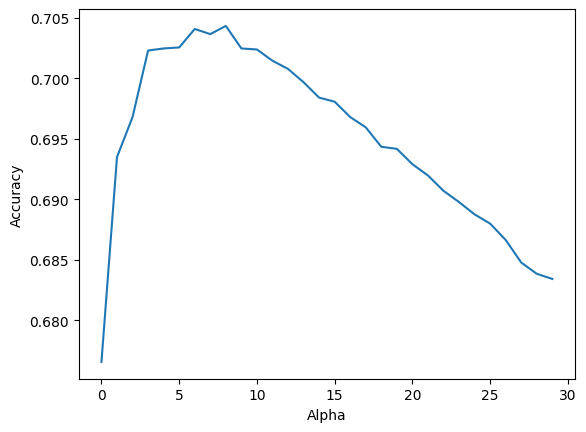

In [24]:
plt.plot(alpha,performance)
plt.xlabel('Alpha')
plt.ylabel('Accuracy')

### Performance with and withour stopwords

In [27]:
## With Stop Words
performance = []
stopword_remove = [True,False]
train_x  = preprocess(raw_train_x)
for stopword in stopword_remove:
    vocab = build_vocab(train_x)
    vocab = clean_vocab(vocab,stopwords_removal=stopword)
    train_df = transform(train_x, vocab, train_y)
    nb_classifier = Naive_bayes(1)
    nb_classifier.train(train_df,vocab)
    preds = nb_classifier.predict(dev_x)
    performance.append((preds == dev_y).sum()/len(preds))


Text(0, 0.5, 'Accuracy')

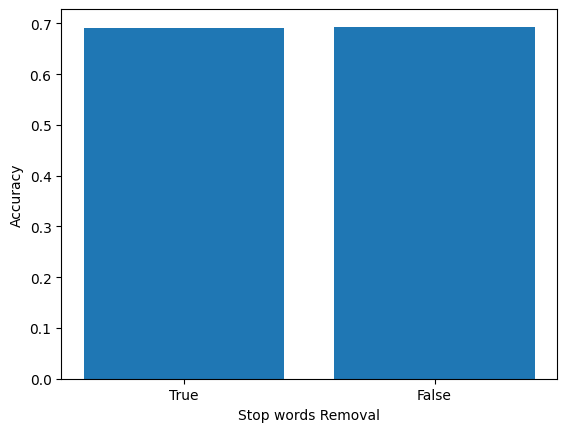

In [21]:
plt.bar(np.array(stopword_remove).astype(str),performance)
plt.xlabel('Stop words Removal')
plt.ylabel('Accuracy')

### Performance with different thershold for rare words

In [25]:

performance = []
rare_words_removed = []
train_x  = preprocess(raw_train_x)
for min_theshold in [0,5,10,25,50,100]:
    vocab = build_vocab(train_x)
    vocab = clean_vocab(vocab,min_theshold=min_theshold)
    train_df = transform(train_x, vocab, train_y)
    nb_classifier = Naive_bayes(1)
    nb_classifier.train(train_df,vocab)
    rare_words_removed.append(min_theshold)
    preds = nb_classifier.predict(dev_x)
    performance.append((preds == dev_y).sum()/len(preds))

Text(0, 0.5, 'Accuracy')

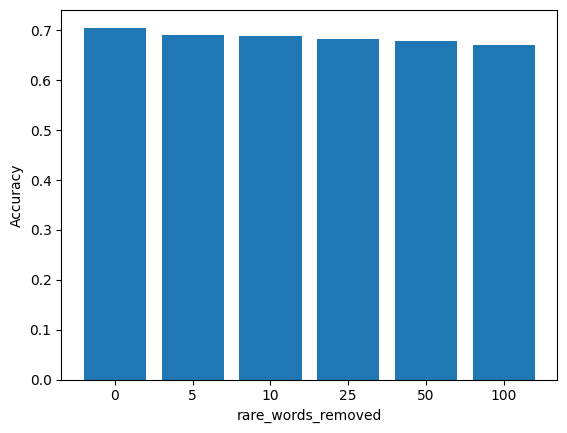

In [26]:
plt.bar(np.array(rare_words_removed).astype(str),performance)
plt.xlabel('rare_words_removed')
plt.ylabel('Accuracy')